🧠 Initializing Model Training...
   Loaded Data: 2189 rows
   ⚙️  Encoding Features...
   Training with 380 features.
   Train Set: 1586 rows (2015-2022)
   Test Set:  603 rows (2023-2025)
   🔥 Training XGBoost Regressor...
[0]	validation_0-rmse:258.71711	validation_1-rmse:493.81500
[100]	validation_0-rmse:135.37397	validation_1-rmse:366.52439
[200]	validation_0-rmse:110.32797	validation_1-rmse:348.21891
[300]	validation_0-rmse:93.85748	validation_1-rmse:338.08260
[400]	validation_0-rmse:81.37289	validation_1-rmse:330.09213
[500]	validation_0-rmse:71.36116	validation_1-rmse:325.07573
[600]	validation_0-rmse:63.20403	validation_1-rmse:321.41063
[700]	validation_0-rmse:56.19577	validation_1-rmse:317.48066
[800]	validation_0-rmse:50.98345	validation_1-rmse:314.40257
[900]	validation_0-rmse:46.71585	validation_1-rmse:312.36690
[999]	validation_0-rmse:42.81065	validation_1-rmse:310.74331

   📊 Model Evaluation:
      MAE:  $237.88
      RMSE: $310.74
      R²:   0.4617

   🌟 Top 10 Feature 

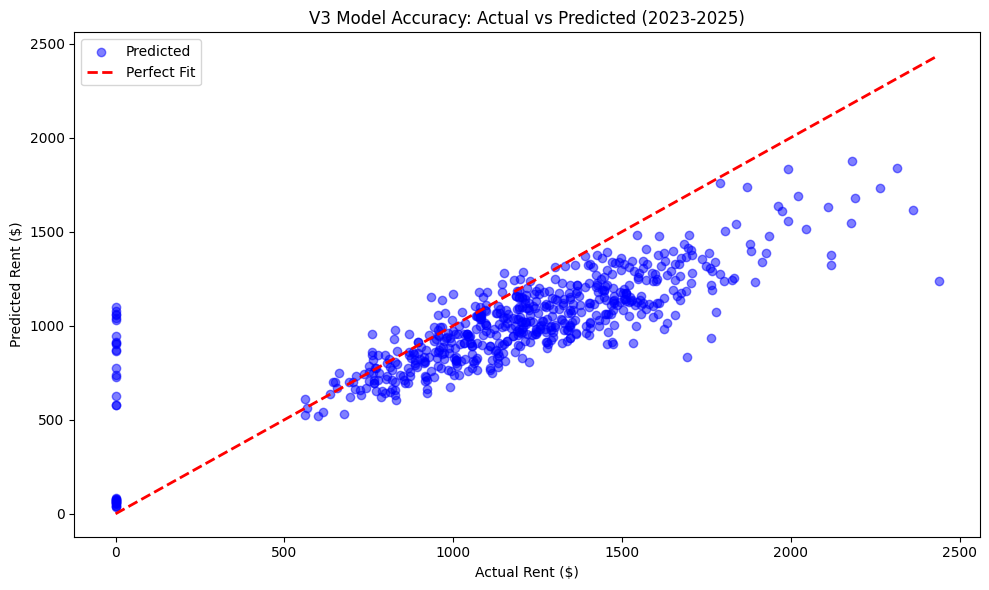

In [17]:
# =========================================================
# V3 STEP 3: THE BRAIN (Model Training) 🧠
# =========================================================
# Goal: Train XGBoost with Macro-Economic Features (Fixed for XGBoost 2.0+)

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import os

# 1. SETUP
BASE_DIR = ".." 
DATA_FILE = os.path.join(BASE_DIR, "data/processed", "hybrid_v3_dataset.csv")
MODEL_DIR = os.path.join(BASE_DIR, "models")

print("🧠 Initializing Model Training...")

# 2. LOAD DATA
try:
    df = pd.read_csv(DATA_FILE)
    print(f"   Loaded Data: {len(df)} rows")
    
    # Drop rows where Target (Rent) is missing
    df = df.dropna(subset=['Average rent ($)'])
    
    # 3. FEATURE ENGINEERING
    # Features (Macro + Year)
    target = 'Average rent ($)'
    
    # One-Hot Encode City (and Province/Region)
    print("   ⚙️  Encoding Features...")
    df_encoded = pd.get_dummies(df, columns=['City', 'Province', 'Region_Map'], drop_first=True)
    
    # Define Feature Columns (Exclude Target & Metadata)
    exclude_cols = [target, 'Turnover_Rate', 'Total_Units', 'Buy_Price', 'Intl_Students_Prov']
    feature_cols = [c for c in df_encoded.columns if c not in exclude_cols]
    
    # Ensure purely numeric features
    feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_encoded[c])]
    
    print(f"   Training with {len(feature_cols)} features.")

    # 4. SPLIT DATA (Time-Based Split)
    # Train: 2015-2022
    # Test: 2023-2025 (Predicting the recent inflation spike)
    train_df = df_encoded[df_encoded['Year'] < 2023]
    test_df = df_encoded[df_encoded['Year'] >= 2023]
    
    X_train = train_df[feature_cols]
    y_train = train_df[target]
    X_test = test_df[feature_cols]
    y_test = test_df[target]
    
    print(f"   Train Set: {len(X_train)} rows (2015-2022)")
    print(f"   Test Set:  {len(X_test)} rows (2023-2025)")

    # 5. TRAIN XGBOOST
    print("   🔥 Training XGBoost Regressor...")
    
    # FIX: 'early_stopping_rounds' is now passed here in the constructor
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=50 
    )
    
    model.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    # 6. EVALUATE
    print("\n   📊 Model Evaluation:")
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    print(f"      MAE:  ${mae:.2f}")
    print(f"      RMSE: ${rmse:.2f}")
    print(f"      R²:   {r2:.4f}")

    # 7. FEATURE IMPORTANCE
    print("\n   🌟 Top 10 Feature Importance:")
    importance = model.feature_importances_
    feat_imp = pd.DataFrame({'Feature': feature_cols, 'Importance': importance})
    feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(10)
    print(feat_imp)
    
    # Save Model
    joblib.dump(model, f"{MODEL_DIR}/xgb_macro_v3.pkl")
    print(f"\n   ✅ Model Saved to {MODEL_DIR}/xgb_macro_v3.pkl")
    
    OUTPUT_DIR = os.path.join(BASE_DIR, "output")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Plot Predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, alpha=0.5, color='blue', label='Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
    plt.xlabel('Actual Rent ($)')
    plt.ylabel('Predicted Rent ($)')
    plt.title('V3 Model Accuracy: Actual vs Predicted (2023-2025)')
    plt.legend()
    plt.tight_layout()

    save_path = os.path.join(OUTPUT_DIR, 'v3_accuracy_plot.png')
    plt.savefig(save_path)
    print(f"   ✅ Prediction Plot saved to: {save_path}")

except Exception as e:
    print(f"❌ TRAINING ERROR: {e}")